In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load Data

In [5]:
df = pd.read_excel('../data/burnside2.xls')

# Create Groups

In [30]:
country_idx, countries = pd.factorize(df.Country)

# Mean Model

In [74]:
coords = {'country':countries}


with pm.Model(coords=coords) as unpooled:
    fixed_effect = pm.Normal('fixed_effect', mu=0, sigma=1, dims=['country'])
    mu = pm.Deterministic('mu', fixed_effect[country_idx])

    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df.GDPG)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


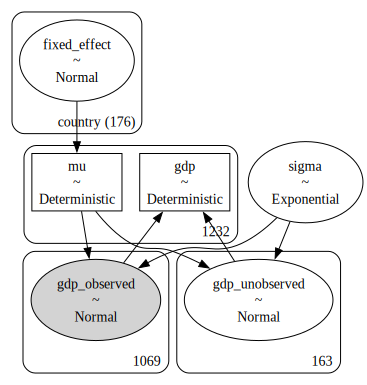

In [75]:
pm.model_to_graphviz(unpooled)

In [76]:
with unpooled:
    idata = pm.sample(init='jitter+adapt_diag_grad')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fixed_effect, sigma, gdp_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


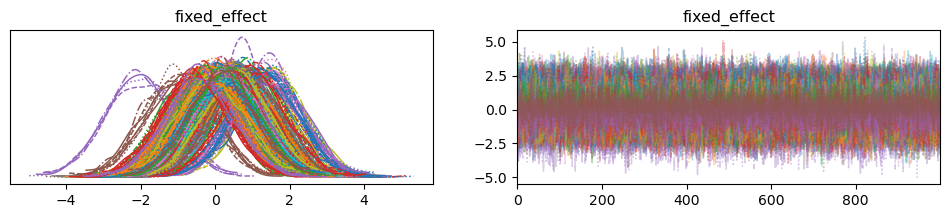

In [77]:
az.plot_trace(idata, var_names=['fixed_effect']);

In [81]:
with unpooled:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x296885460>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_observed]


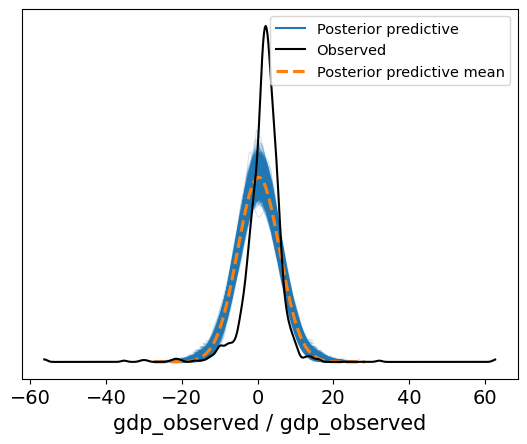

In [82]:
az.plot_ppc(idata);

# Partially Pooled

In [92]:
with pm.Model(coords=coords) as partially_pooled:
    fixed_effect_mu = pm.Normal('fixed_effect_mu', mu=0, sigma=1)
    fixed_effect_sigma = pm.HalfNormal('fixed_effect_sigma', sigma=1)
    fixed_effect_offset = pm.ZeroSumNormal('fixed_effect_offset', sigma=1, dims=['country'])
    fixed_effect = pm.Deterministic('fixed_effect', fixed_effect_mu + fixed_effect_sigma * fixed_effect_offset,
                                    dims=['country'])

    mu = pm.Deterministic('mu', fixed_effect[country_idx])
    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df.GDPG)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/model/core.py:1357: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


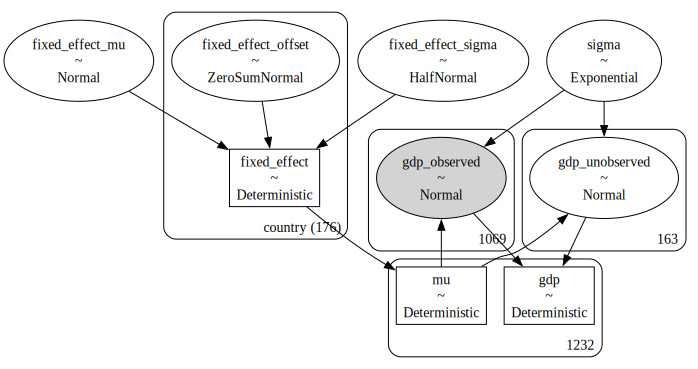

In [93]:
pm.model_to_graphviz(partially_pooled)

In [87]:
with partially_pooled:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fixed_effect_mu, fixed_effect_sigma, fixed_effect, sigma, gdp_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [90]:
az.summary(idata, var_names=['~mu', '~gdp'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fixed_effect_mu,1.325,0.189,0.990,1.697,0.004,0.003,2293.0,2365.0,1.00
fixed_effect[ALBANIA],0.511,1.287,-1.955,2.860,0.019,0.019,4661.0,3075.0,1.00
fixed_effect[ALGERIA],1.245,1.145,-0.846,3.591,0.013,0.015,7550.0,2771.0,1.00
fixed_effect[ANGOLA],0.525,1.378,-2.124,3.050,0.022,0.019,3987.0,2890.0,1.00
fixed_effect[ANTIGUA AND BARBUDA],2.188,1.307,-0.204,4.695,0.019,0.017,4957.0,2834.0,1.00
...,...,...,...,...,...,...,...,...,...
gdp_unobserved[160],1.341,5.264,-8.510,11.094,0.059,0.095,7970.0,2329.0,1.00
gdp_unobserved[161],1.233,5.237,-8.509,11.120,0.059,0.085,7933.0,3149.0,1.00
gdp_unobserved[162],1.376,5.329,-8.396,11.804,0.068,0.091,6180.0,3003.0,1.00
fixed_effect_sigma,1.441,0.229,0.996,1.854,0.012,0.008,370.0,556.0,1.01


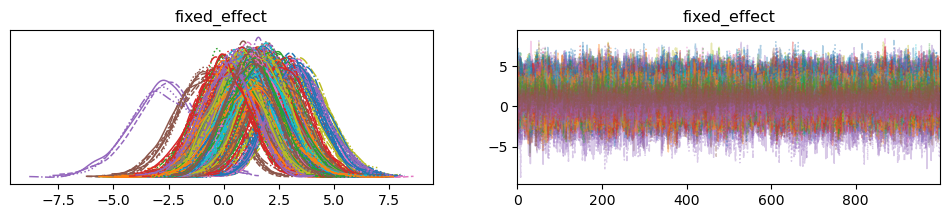

In [91]:
az.plot_trace(idata, var_names=['fixed_effect']);